## 4. 이미지 어디까지 우려볼까

### 목  차
1. 데이터 불러오기
2. 데이터 전처리 및 함수 만들기   
   1) cutmix 적용함수   
   2) mixup 적용함수   
   3) 데이터 전처리 함수   
3. 모델 만들기
4. 모델 훈련하기
5. Performance 비교

### 1. 데이터 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터셋: stanford_dogs
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompletePK8K2Q/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompletePK8K2Q/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [4]:
# 데이터셋 클래스 개수
NUM_CLASSES = ds_info.features["label"].num_classes
NUM_CLASSES

120

### 2. 데이터 전처리 및 함수 만들기

#### 1) cutmix 적용함수

In [5]:
# clip_box

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [6]:
# mix two images

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_a의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_a의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [7]:
# mix two labels

def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [8]:
# cutmix 함수 구성

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


#### 2) mixup 적용함수

In [9]:
# function for mixup

def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [10]:
# mixup 함수구성

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


#### 3) 데이터 전처리 함수

In [11]:
# 학습 데이터와 검증 데이터에 normalizing 과 resizing 적용

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

print('=3')

=3


In [12]:
# Augmentation 함수

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


In [13]:
# 원핫 인코딩 적용 함수

def onehot(image, label, num_classes=120):
    label_one_hot = tf.one_hot(label, num_classes)
    return image, label_one_hot

In [14]:
# 데이터셋 가공 메인함수

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,  # normalizing 과 resizing 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment  # augment 함수 적용
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,  # cutmix augment 함수 적용
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,  # mixup augment 함수 적용
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,  # one - hot encoding
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [15]:
# 데이터 구성
BATCH_SIZE = 16

ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)
print('=3')

=3


In [16]:
# 이미지 확인 함수
def draw_ds_train(ds_train, batch_size=16, row=6, col=4):
    row = min(row, batch_size//col)  # row 재설정
    
    # 데이터셋에서 배치 사이즈(=16개)만큼 1번만 이미지 가져오기
    for i, (image, label) in enumerate(ds_train.take(1)):
        
        plt.figure(figsize=(8,int(8*row/col)))  # 8x8 크기
        for j in range(row*col):
            plt.subplot(row,col,j+1)
            plt.axis('off')
            plt.imshow(image[j,])  # 가져온 이미지(16개) 하나씩 출력
                    
        plt.tight_layout()
        plt.show()

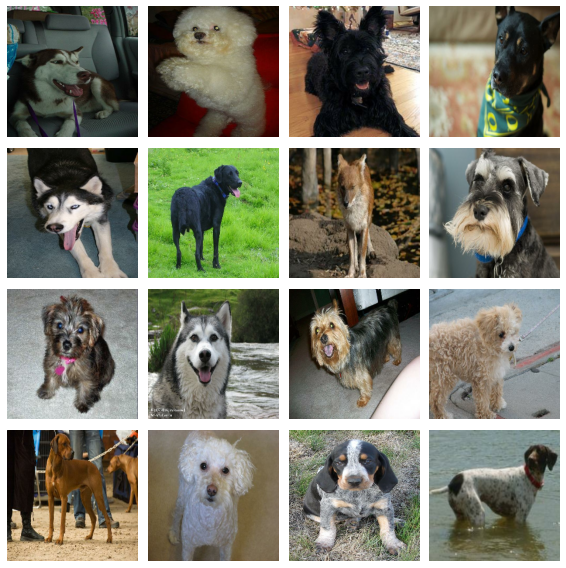

In [17]:
# No Aug 이미지 확인
draw_ds_train(ds_train_no_aug, BATCH_SIZE)

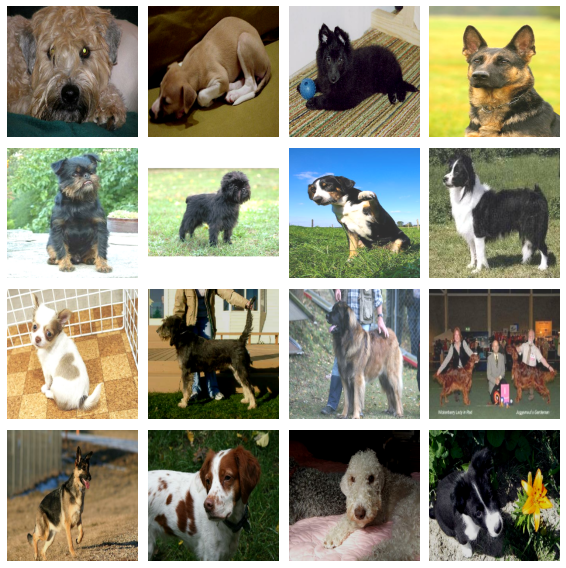

In [18]:
# Aug 적용 이미지 확인
draw_ds_train(ds_train_aug, BATCH_SIZE)

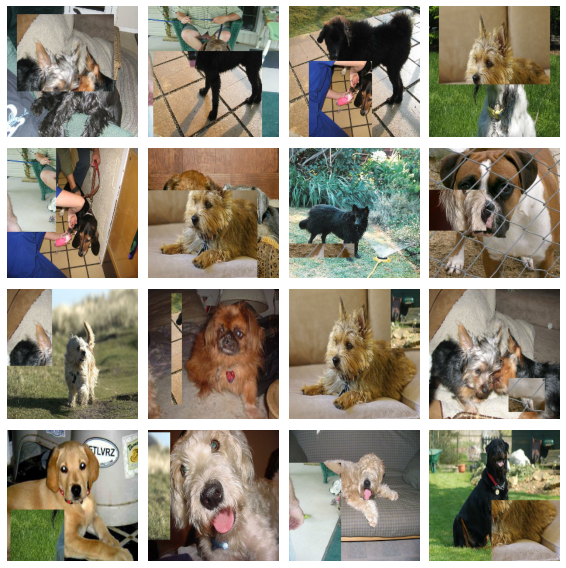

In [19]:
# CutMix 적용 이미지 확인
draw_ds_train(ds_train_aug_cutmix, BATCH_SIZE)

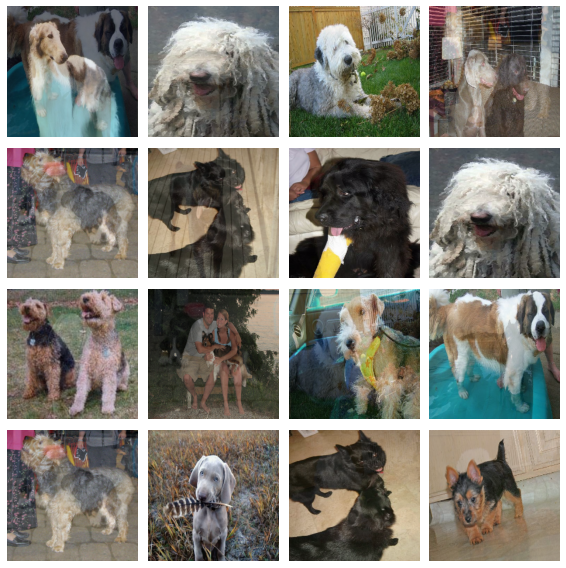

In [21]:
# Mixup 적용 이미지 확인
draw_ds_train(ds_train_aug_mixup, BATCH_SIZE)

### 3. 모델 만들기

In [22]:
# ResNet50 생성 함수

def create_ResNet50(include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='avg',
                    num_classes=120,
                    activation='softmax'):
                    
    resnet50 = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=include_top,
            weights=weights,
            input_shape=input_shape,
            pooling=pooling,
        ),
        keras.layers.Dense(num_classes, activation=activation)
    ])
    return resnet50

In [23]:
# ResNet50 모델 생성

resnet50_no_aug = create_ResNet50(num_classes=NUM_CLASSES)  
resnet50_aug = create_ResNet50(num_classes=NUM_CLASSES)  
resnet50_aug_cutmix = create_ResNet50(num_classes=NUM_CLASSES) 
resnet50_aug_mixup = create_ResNet50(num_classes=NUM_CLASSES) 

94781440/94765736 [==============================] - 0s 0us/step


### 4. 모델 훈련하기

In [24]:
# 하이퍼 파라메터
EPOCH = 20
LEARNING_RATE = 0.01
BATCH_SIZE = 16

In [25]:
# ResNet50 훈련 함수
def compile_and_fit(resnet50,
                    ds_train,
                    ds_test,
                    ds_info,
                    learning_rate=0.01,
                    batch_size=16,
                    epochs=3):
                    
    resnet50.compile(
        loss='categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy'],
    )

    history_resnet50 = resnet50.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history_resnet50

In [26]:
# No Augmentation
history_resnet50_no_aug = compile_and_fit(
    resnet50_no_aug,
    ds_train_no_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

Epoch 1/20
750/750 [==============================] - 108s 120ms/step - loss: 2.2279 - accuracy: 0.4428 - val_loss: 3.1057 - val_accuracy: 0.2502
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 0.6795 - accuracy: 0.8115 - val_loss: 1.0237 - val_accuracy: 0.6974
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 0.1864 - accuracy: 0.9670 - val_loss: 0.9310 - val_accuracy: 0.7239
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0501 - accuracy: 0.9971 - val_loss: 0.9006 - val_accuracy: 0.7396
Epoch 5/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0203 - accuracy: 0.9997 - val_loss: 0.9140 - val_accuracy: 0.7401
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0159 - accuracy: 0.9998 - val_loss: 0.9476 - val_accuracy: 0.7367
Epoch 7/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0440 - accuracy: 0.9962 - val_loss: 1.0581 - val_a

In [27]:
# Augmentation만 사용
history_resnet50_aug = compile_and_fit(
    resnet50_aug,
    ds_train_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

Epoch 1/20
750/750 [==============================] - 95s 118ms/step - loss: 2.2842 - accuracy: 0.4283 - val_loss: 2.8574 - val_accuracy: 0.2837
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 0.9559 - accuracy: 0.7289 - val_loss: 1.1530 - val_accuracy: 0.6622
Epoch 3/20
750/750 [==============================] - 93s 123ms/step - loss: 0.5280 - accuracy: 0.8537 - val_loss: 1.3129 - val_accuracy: 0.6292
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 0.3478 - accuracy: 0.9094 - val_loss: 1.0499 - val_accuracy: 0.6969
Epoch 5/20
750/750 [==============================] - 89s 118ms/step - loss: 0.1831 - accuracy: 0.9604 - val_loss: 1.0774 - val_accuracy: 0.6950
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0839 - accuracy: 0.9869 - val_loss: 1.0030 - val_accuracy: 0.7177
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0503 - accuracy: 0.9941 - val_loss: 0.9650 - val_ac

In [28]:
# Augmentaion + CutMix 적용
history_resnet50_aug_cutmix = compile_and_fit(
    resnet50_aug_cutmix,
    ds_train_aug_cutmix,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

Epoch 1/20
750/750 [==============================] - 97s 120ms/step - loss: 3.8266 - accuracy: 0.2080 - val_loss: 3.5017 - val_accuracy: 0.1852
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 2.9244 - accuracy: 0.4381 - val_loss: 1.4827 - val_accuracy: 0.5922
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 2.5867 - accuracy: 0.5466 - val_loss: 1.2231 - val_accuracy: 0.6644
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 2.3738 - accuracy: 0.6256 - val_loss: 1.2847 - val_accuracy: 0.6544
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 2.2375 - accuracy: 0.6648 - val_loss: 1.1563 - val_accuracy: 0.6858
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 2.1225 - accuracy: 0.7026 - val_loss: 1.1299 - val_accuracy: 0.6939
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 2.0261 - accuracy: 0.7305 - val_loss: 1.1583 - val_ac

In [29]:
# Augmentaion + MixUp 적용
history_resnet50_aug_mixup = compile_and_fit(
    resnet50_aug_mixup,
    ds_train_aug_mixup,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

Epoch 1/20
750/750 [==============================] - 97s 120ms/step - loss: 3.7369 - accuracy: 0.2438 - val_loss: 4.0856 - val_accuracy: 0.1177
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 2.8630 - accuracy: 0.4771 - val_loss: 1.6269 - val_accuracy: 0.5414
Epoch 3/20
750/750 [==============================] - 90s 119ms/step - loss: 2.5400 - accuracy: 0.5987 - val_loss: 1.3674 - val_accuracy: 0.6142
Epoch 4/20
750/750 [==============================] - 94s 126ms/step - loss: 2.3801 - accuracy: 0.6622 - val_loss: 1.2604 - val_accuracy: 0.6447
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 2.2369 - accuracy: 0.7189 - val_loss: 1.3195 - val_accuracy: 0.6322
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 2.1364 - accuracy: 0.7554 - val_loss: 1.2616 - val_accuracy: 0.6557
Epoch 7/20
750/750 [==============================] - 92s 122ms/step - loss: 2.0677 - accuracy: 0.7804 - val_loss: 1.3406 - val_ac

### 5. Performance 비교

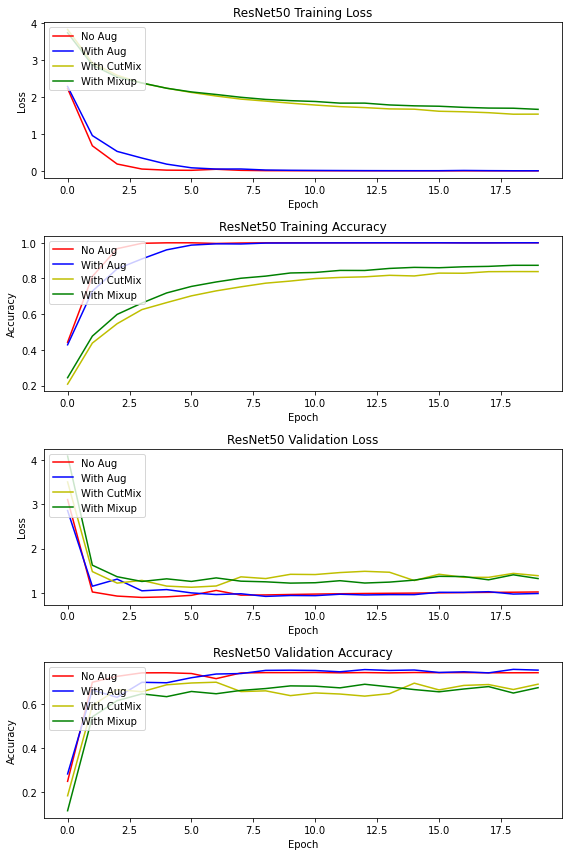

In [32]:
# 모델별 학습과정 시각확

plt.subplots(figsize=(8,12))

# Training Loss 시각화
plt.subplot(411)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'g')
plt.title('ResNet50 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# Training Accuracy 시각화
plt.subplot(412)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'g')
plt.title('ResNet50 Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# Validation Loss 시각화
plt.subplot(413)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'g')
plt.title('ResNet50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# Validation Accuracy 시각화
plt.subplot(414)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

plt.tight_layout()
plt.show()

#### 모델별 performance 요약 (epoch=20, lr=0.01)

|model|train_loss|train_accuracy|valid_loss|valid_accuracy|
|--|:--:|:--:|:--:|:--:|
|no augumentation|0.0019|1.0000|1.0237|**0.7403**|
|augumentation|0.0040|1.0000|0.9892|**0.7520**|
|cutmix|1.5359|0.8385|1.3905|**0.6885**|
|mixup|1.6652|0.8737|1.3254|**0.6728**|

### 6. 결 론

  * ResNet50 기준 augmentation을 사용한 모델이 사용하지 않은 모델보다 성과가 좋게 나옴
  * 그러나 epoch=20 수준에서 cutmix나 mixup의 성과가 더 나아지지는 않음
  * 논문에서는 CutMix를 쓰지 않으면 약 150에포크에서 과적합이 일어나지만 CutMix의 경우 과적합이 일어나지 않고 꾸준히 감소한 것으로 보인다고 하고 있어, epoch=20 으로는 효과를 판단하기 어려운 것 같음
  * cutmix와 mixup의 성과비교에서는 cutmix의 성과가 좋게 나옴     


 [ 회 고 ] 
  * 네이버 클로바(CLOVA)에서 발표한 CutMix 기법의 성과가 좋을 것으로 기대했으나, 기대보다 낮게 나와서 무엇이 원인일까 궁금함
  * epoch수가 작은 것, augmentation방식의 다양성 부족, 하이퍼 파라메터 조정 등을 생각해 볼 수 있을 것 같음
  * 가위, 바위, 보 노드에서 augmentation을 사용해 봤는데, 성과가 크게 개선되지 않았던 기억이 있음. 
  * 데이터 cost가 비싼 상황에서 augmentation의 기법을 잘 활용할 수 있는 추가적인 방법을 찾아봐야 할 것 같음


 < reference >
   - (paper) CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features
   - https://dacon.io/forum/405852
   - https://hongl.tistory.com/223
   - https://ffighting.tistory.com/entry/CutMix-%ED%95%B5%EC%8B%AC-%EB%A6%AC%EB%B7%B0
